# Rotating sinusoidal bump - network stability

* What do the network weights need to look like to have continually stable recurrent activity?

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from bindsnet.network import Network
from bindsnet.network.monitors import Monitor
import bindsnet.analysis.plotting
from bindsnet.network.topology import Connection

from homeostatic_LIF_neuron import HomestaticLIFNodes
from homeostatic_STDP import HomeostaticSTDP

plt.style.use('seaborn-notebook')
plt.rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
plt.rc('text', usetex=True)
np.random.seed(7) # seed so plots are repeatable
%matplotlib inline
# need the %matplotlib inline for the following to work
plt.rc('figure', figsize = [8,6]) # paper figures should be width 8 (full linewidth) to have nicely readable text

In [41]:
def get_sinusoidal_weight_matrix(num_neurons: int):
	n_from, n_to = torch.meshgrid(torch.arange(num_neurons),torch.arange(num_neurons))
	return (1+torch.sin(2.0*np.pi*(n_to - n_from)/num_neurons)) / 2

def get_rotating_sine(time: int, num_neurons: int, period: int):
	t, x = torch.meshgrid(torch.arange(time),torch.arange(num_neurons))
	theta = x*period/num_neurons - t
	return (1+torch.sin(2.0*np.pi/period * theta)) / 2


Create the ideal weight matrix for the network

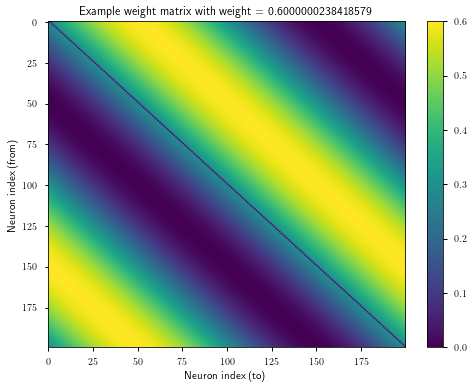

In [54]:
num_neurons = 200
weight_range = torch.arange(0,0.8,0.2).__reversed__()

scale_max_min = lambda matrix, max, min: (max - min)*matrix + min

def get_weight_matrix(weight: float): # this matrix is now nonnegative because inhibition is separate
	weight_matrix = scale_max_min(get_sinusoidal_weight_matrix(num_neurons), weight, 0)
	weight_matrix -= torch.diag(torch.diag(weight_matrix))
	return weight_matrix

	# weight_matrix = scale_max_min(get_biased_gaussian_derivative_weight_matrix(num_neurons, bump_speed, sigma*5), weight, -weight)

	# assym
	# weight_matrix = scale_max_min(get_linear_weight_matrix(num_neurons, bump_speed), weight-inhibition_weight, 0)
	# weight_matrix -= torch.diag(torch.diag(weight_matrix))
	# w = get_biased_gaussian_weight_matrix(num_neurons, 0, num_neurons//30)[0,:]
	# w2 = np.convolve(np.convolve(w,w,'same'), kernel(delta_t),'same')[:-1]
	# return scale_max_min(roll_tensor_rows(torch.tile(torch.tensor(w2),(num_neurons,1)), torch.arange(num_neurons) - num_neurons//2), weight, -weight)

weight_matrix = get_weight_matrix(weight_range[0])

plt.imshow(weight_matrix)
plt.axis('auto')
plt.title(f'Example weight matrix with weight = {weight_range[0]}')
plt.ylabel('Neuron index (from)')
plt.xlabel('Neuron index (to)')
plt.colorbar()
plt.show()

Create the network of LIF neurons and simulate it with the ideal weight matrix. Reduce the magnitude of the weights over time to see when the firing stops

In [145]:
time = 1000
network = Network()

# Create and add input, output layers.
lif_layer = HomestaticLIFNodes(n=num_neurons, homeostatic_traces=True, traces=True, traces_additive=True, tc_decay=10, thresh=-50, rest=-70, reset=-70, refrac=1)

network.add_layer(layer=lif_layer, name='LIF')

recurrent_connection = Connection(
    source=lif_layer,
    target=lif_layer,
	update_rule = HomeostaticSTDP,
	nu=0,
	gamma = 0,
	wmin=0,
    w=torch.zeros((lif_layer.n,lif_layer.n)),
)
network.add_connection(connection=recurrent_connection, source='LIF', target='LIF')
# inhibitory_connection = Connection(
# 	source=lif_layer,
#     target=lif_layer,
# 	update_rule = HomeostaticSTDP,
# 	nu=0,
# 	gamma = 0,
#     w = inhibition_weight * torch.ones((lif_layer.n,lif_layer.n)),
# )
# # need to patch bindsnet so this works - otherwise connection gets overwritten
# network.add_connection(connection=inhibitory_connection, source='LIF', target='LIF')

np.random.seed(7)
weight_range = torch.arange(0,0.9,0.4).__reversed__()
input_voltage = get_rotating_sine(num_neurons, num_neurons, num_neurons)
input_voltage += 0.2*torch.randn_like(input_voltage)

# Create and add monitors for spikes and voltages
# monitor = Monitor(obj=lif_layer, state_vars=('s', 'v', 'r'), time=len(weight_range)*time+num_neurons)
monitor = Monitor(obj=lif_layer, state_vars=('s', 'v', 'r'), time=num_neurons+time)
network.add_monitor(monitor=monitor, name='LIF_monitor')

# Simulate network
input_weight = 4
network.run(inputs = {'LIF': input_weight*input_voltage}, time=num_neurons, progress_bar=True)
# reduce the weights in the connection matrix and see when activity no longer persists
recurrent_connection.w.data = get_weight_matrix(0.6025)
network.run(inputs = {}, time=time, progress_bar=True)
# network.run(inputs = {}, time=time, progress_bar=True)
# network.run(inputs = {}, time=time, progress_bar=True)
# for weight in weight_range[3:]:
# 	recurrent_connection.w.data = get_weight_matrix(weight)
# 	network.run(inputs = {}, time=time, progress_bar=True)

# Retrieve data from monitors for analysis
spikes = monitor.get('s')
voltages = monitor.get('v')
rates = monitor.get('r')

Network spiking - reduces as the input decreases, but dies after the weight drops below 3

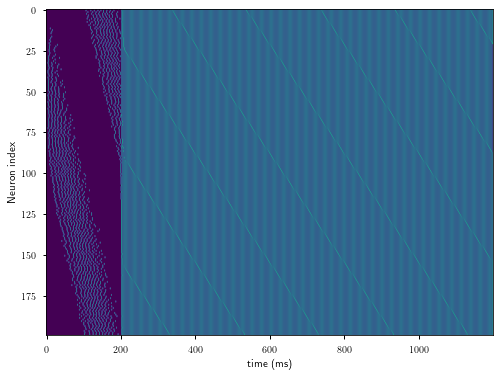

In [146]:
plt.imshow(spikes.squeeze().T)
plt.xlabel('time (ms)')
plt.ylabel('Neuron index')
plt.axis('auto')
plt.show()

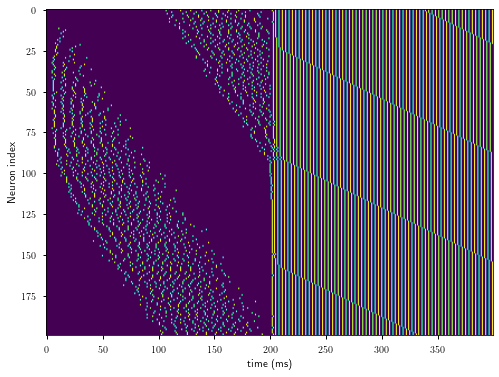

In [147]:
plt.imshow(spikes.squeeze().T[:,:num_neurons+200])
plt.xlabel('time (ms)')
plt.ylabel('Neuron index')
plt.axis('auto')
plt.show()

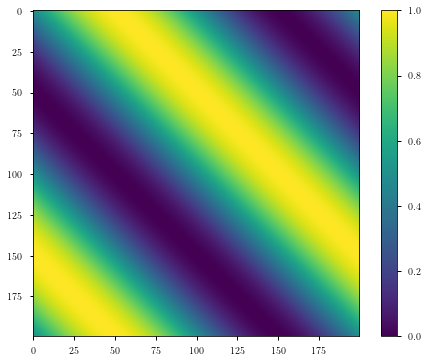

In [67]:
plt.imshow(input_voltage)
plt.colorbar()

ValueError: x and y must have same first dimension, but have shapes torch.Size([5]) and (4,)

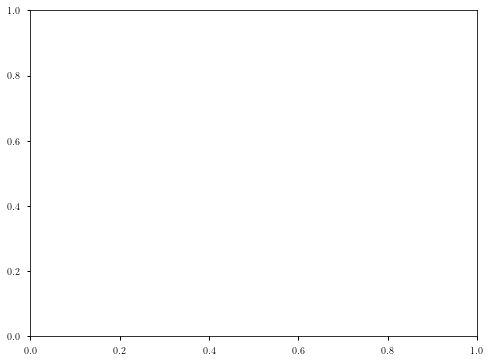

In [48]:
plt.plot(weight_range, [spike_window.sum()/num_neurons for spike_window in spikes.split(1000,dim=0)[1:]])
plt.xlabel('weight matrix max value')
plt.ylabel('average neuron spike rate')
plt.title('neuron spike rate during self-sustaining activity as weights are reduced')
plt.gca().invert_xaxis()
plt.show()